## The entire experimental process is as follows:
- Data preprocessing (not included in this document)
- Train three models to obtain three sets of rule sets
    - C4.5
    - JRIP
    - PART
    - Note that the training and parameter tuning of JRIP and PART have been completed in WEKA. This file reads the WEKA results
- Calculate the feature SHAP value and avg importance of rules
- Rule selection: selecting rules from three rule sets by combining shap value, coverage, etc. This process attempts to size rule sets of different sizes and compares performance
- RBS: confirm that the size of the final rule set is 300, form the final RBS, and test the performance
- Real-time prediction: artificial manufacturing of missing values, testing the performance of RBS with data containing missing values; In the processing section of missing values, explore the feature offset and γ, try different γ, and compare performance

### read data

In [1]:
# read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import chain
from tqdm import tqdm,tqdm_notebook
import random
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = Path('D:/ssd')

# subset1  train model, generate rule set
df_use = pd.read_csv(DATA_PATH / 'subset1.csv')

random_state = 2023
feature_used = set(df_use.columns) - set(['disk_id', 'ds', 'model','label'])

df_test = df_use.sample(frac=0.3, random_state=random_state)
train_idxs = set(df_use.index) - set(df_test.index)
df_train = df_use.loc[train_idxs]
print(f"train_size({len(df_train)})/test_size({len(df_test)})")

X_train,X_test = df_train[feature_used],df_test[feature_used]
y_train,y_test = df_train['label'],df_test['label']

train_size(50900)/test_size(21814)


## train model with subset1， get rule sets
- C4.5
- JRIP (read file generated from weka)
- PART (read file  genrated from weak)

In [4]:
from sklearn.tree import DecisionTreeClassifier

# clf = DecisionTreeClassifier(
#     max_depth=25, ## max depth
# #     max_leaf_nodes=400,
# #     ccp_alpha=0.0005,
#     random_state=2023,
#     criterion='entropy')

clf = DecisionTreeClassifier(
    max_depth=25, ## max depth
#     max_leaf_nodes=40,## max leaf nodes
#     min_samples_leaf=3,
#     min_samples_split=1,
    ccp_alpha=0.0002,
    random_state=2023,
    criterion='entropy')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.98      0.99      0.99     20005
         yes       0.89      0.82      0.85      1809

    accuracy                           0.98     21814
   macro avg       0.94      0.91      0.92     21814
weighted avg       0.98      0.98      0.98     21814



In [36]:
df_use

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,n_195,r_195,n_196,r_196,r_197,r_198,n_199,r_199,r_206,label
0,406,2018-10-01,MA1,130.0,4.137765e+09,98.0,0.0,100.0,35996.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,no
1,406,2018-10-02,MA1,130.0,4.175147e+09,98.0,0.0,100.0,36019.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,no
2,406,2018-10-03,MA1,130.0,4.215511e+09,98.0,0.0,100.0,36043.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,no
3,406,2018-10-04,MA1,130.0,4.254417e+09,98.0,0.0,100.0,36067.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,no
4,406,2018-10-05,MA1,130.0,4.293503e+09,98.0,0.0,100.0,36091.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72709,19055,2018-12-28,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13259.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,no
72710,19055,2018-12-29,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13283.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,no
72711,19055,2018-12-30,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13307.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,no
72712,19055,2018-12-31,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13331.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,no


## shap value

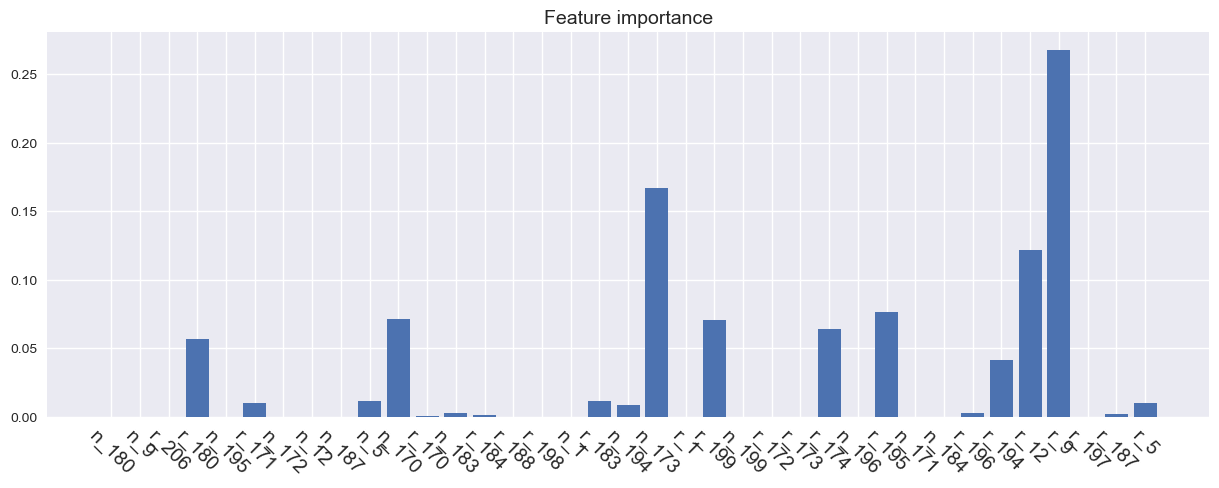

In [5]:
# feature importance
import matplotlib.pyplot as plt; plt.style.use('seaborn')

plt.figure(figsize=(15, 5))
plt.bar(range(len(X_test.columns)), clf.feature_importances_)
plt.xticks(range(len(X_test.columns)), X_test.columns, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

In [38]:
# import shap
# explainer = shap.TreeExplainer(clf) # 引用package并且获得解释器explainer
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")


import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [39]:
shap_values

[array([[-1.47713679e-04,  0.00000000e+00, -2.84590184e-03, ...,
          3.58001036e-03,  0.00000000e+00, -3.74313356e-04],
        [-1.47713679e-04,  0.00000000e+00, -2.84590184e-03, ...,
          3.58001036e-03,  0.00000000e+00, -3.74313356e-04],
        [-1.47713679e-04,  0.00000000e+00, -2.84590184e-03, ...,
          3.58001036e-03,  0.00000000e+00, -3.74313356e-04],
        ...,
        [ 2.25635670e-04,  0.00000000e+00, -6.48118690e-03, ...,
          5.19562552e-03,  0.00000000e+00,  1.63958947e-05],
        [ 2.25635670e-04,  0.00000000e+00, -6.48118690e-03, ...,
          5.23470539e-03,  0.00000000e+00,  1.63958947e-05],
        [ 2.25635670e-04,  0.00000000e+00, -5.59508973e-03, ...,
         -1.18916192e-02,  0.00000000e+00,  2.97466175e-04]]),
 array([[ 1.47713679e-04,  0.00000000e+00,  2.84590184e-03, ...,
         -3.58001036e-03,  0.00000000e+00,  3.74313356e-04],
        [ 1.47713679e-04,  0.00000000e+00,  2.84590184e-03, ...,
         -3.58001036e-03,  0.00000000e

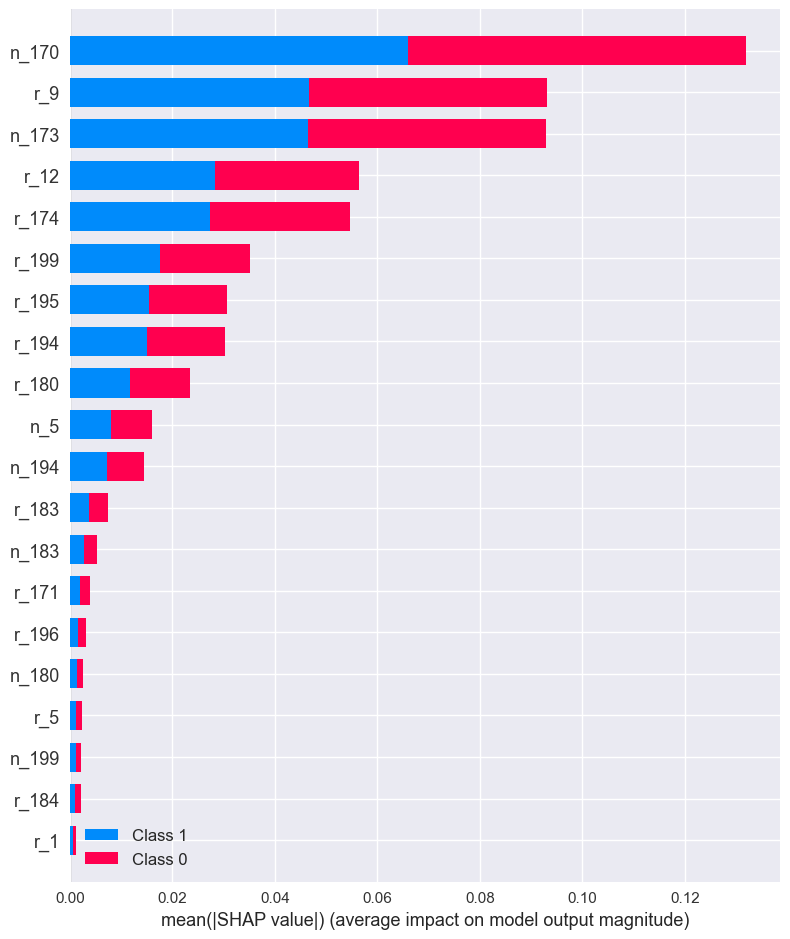

In [69]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

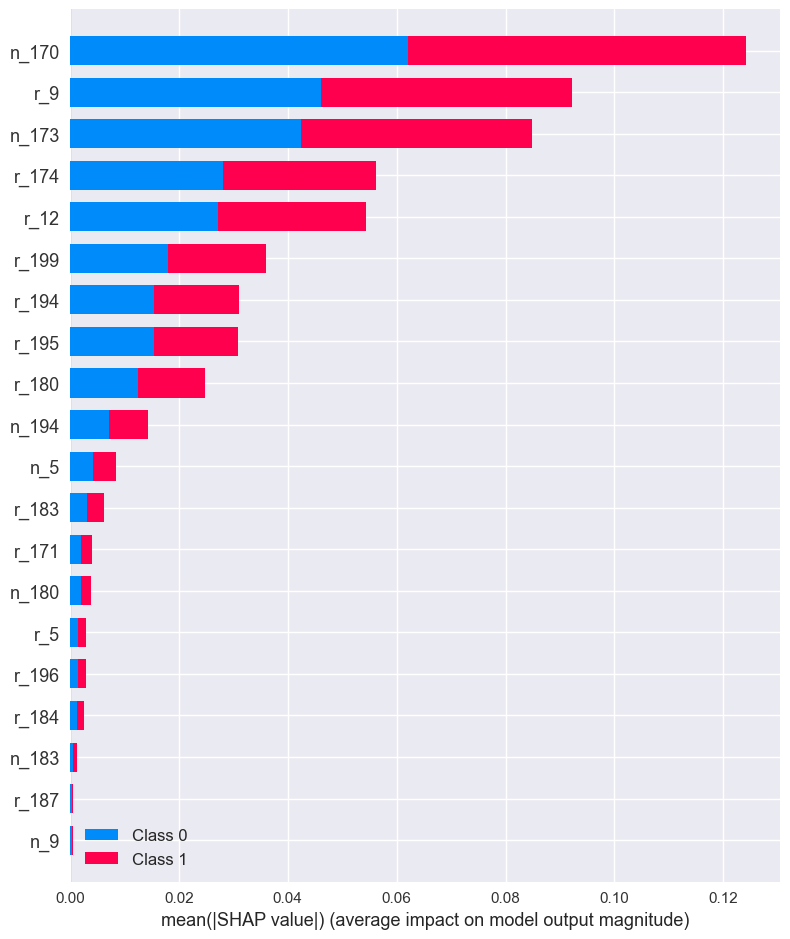

In [40]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [70]:
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
global_importances = np.abs(shap_values).mean(0)[:-1]
global_importances

array([[7.52357593e-03, 5.21853713e-03, 0.00000000e+00, ...,
        6.01041577e-04, 1.61391151e-02, 4.32803760e-04],
       [7.52357593e-03, 5.21853713e-03, 0.00000000e+00, ...,
        6.01041577e-04, 1.61391151e-02, 4.32803760e-04],
       [7.52357593e-03, 5.21853713e-03, 0.00000000e+00, ...,
        6.01041577e-04, 1.61391151e-02, 4.32803760e-04],
       ...,
       [9.78626825e-02, 4.40652724e-03, 0.00000000e+00, ...,
        1.89725116e-03, 2.88718965e-02, 4.89619593e-05],
       [9.76174007e-02, 4.41716381e-03, 0.00000000e+00, ...,
        1.89725116e-03, 2.80029475e-02, 4.89619593e-05],
       [9.76174007e-02, 4.38202947e-03, 0.00000000e+00, ...,
        1.89725116e-03, 2.80029475e-02, 4.89619593e-05]])

In [41]:
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
global_importances = np.abs(shap_values).mean(0)[:-1]
global_importances

array([[1.47713679e-04, 0.00000000e+00, 2.84590184e-03, ...,
        3.58001036e-03, 0.00000000e+00, 3.74313356e-04],
       [1.47713679e-04, 0.00000000e+00, 2.84590184e-03, ...,
        3.58001036e-03, 0.00000000e+00, 3.74313356e-04],
       [1.47713679e-04, 0.00000000e+00, 2.84590184e-03, ...,
        3.58001036e-03, 0.00000000e+00, 3.74313356e-04],
       ...,
       [2.25635670e-04, 0.00000000e+00, 6.48118690e-03, ...,
        5.25920316e-03, 0.00000000e+00, 1.63958947e-05],
       [2.25635670e-04, 0.00000000e+00, 6.48118690e-03, ...,
        5.19562552e-03, 0.00000000e+00, 1.63958947e-05],
       [2.25635670e-04, 0.00000000e+00, 6.48118690e-03, ...,
        5.23470539e-03, 0.00000000e+00, 1.63958947e-05]])

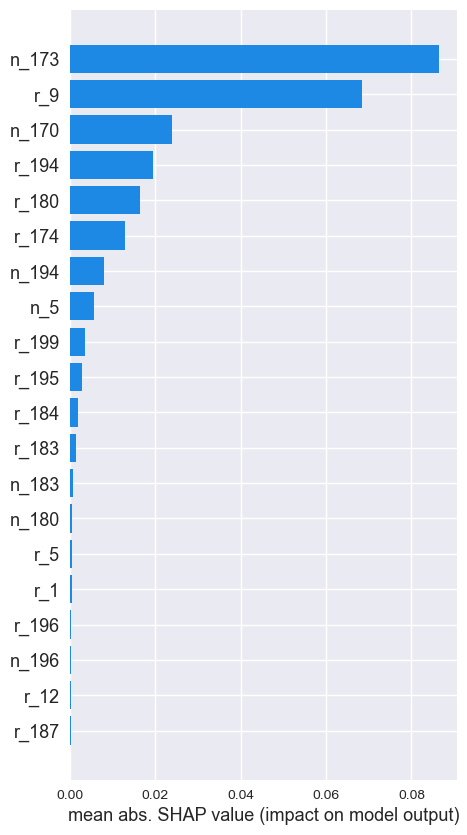

In [42]:
import matplotlib.pyplot as pl

# make a bar chart that shows the global importance of the top 20 features
inds = np.argsort(-global_importances[0])
f = pl.figure(figsize=(5,10))
y_pos = np.arange(20)
inds2 = np.flip(inds[:20], 0)
pl.barh(y_pos, global_importances[0][inds2], align='center', color="#1E88E5")
pl.yticks(y_pos, fontsize=13)
pl.gca().set_yticklabels(X_train.columns[inds2])
pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('none')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)


In [72]:
 global_importances[0][inds2]

array([0.00029049, 0.00029733, 0.0004328 , 0.00059012, 0.00060104,
       0.00065111, 0.00101187, 0.00144689, 0.00159016, 0.00190401,
       0.00306404, 0.00521854, 0.00752358, 0.00934868, 0.01452991,
       0.01613912, 0.01898045, 0.02612968, 0.07124303, 0.0873902 ])

In [43]:
 global_importances[0][inds2]

array([0.00014771, 0.00016522, 0.00019899, 0.00021056, 0.00037431,
       0.00038981, 0.00057181, 0.00079292, 0.00138251, 0.00186725,
       0.0028459 , 0.00358001, 0.00553141, 0.00802636, 0.01300556,
       0.01650138, 0.01945096, 0.02393108, 0.06834672, 0.0864523 ])

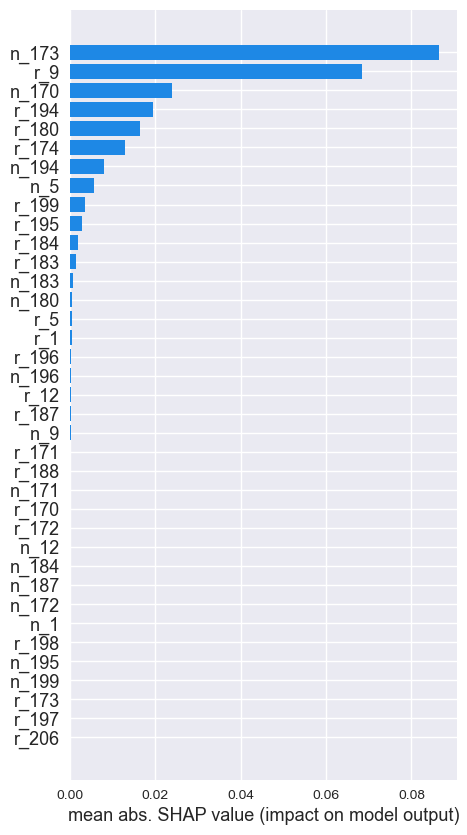

In [44]:
import matplotlib.pyplot as pl

# make a bar chart that shows the global importance of the top 20 features
inds = np.argsort(-global_importances[0])
f = pl.figure(figsize=(5,10))
y_pos = np.arange(37)
inds2 = np.flip(inds[:37], 0)
pl.barh(y_pos, global_importances[0][inds2], align='center', color="#1E88E5")
pl.yticks(y_pos, fontsize=13)
pl.gca().set_yticklabels(X_train.columns[inds2])
pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('none')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)


In [45]:
global_importances[0][inds2]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.10300393e-05, 2.48471363e-05,
       1.46674542e-04, 1.47713679e-04, 1.65219349e-04, 1.98985618e-04,
       2.10557711e-04, 3.74313356e-04, 3.89806887e-04, 5.71807864e-04,
       7.92916076e-04, 1.38251151e-03, 1.86724674e-03, 2.84590184e-03,
       3.58001036e-03, 5.53140612e-03, 8.02635502e-03, 1.30055611e-02,
       1.65013826e-02, 1.94509564e-02, 2.39310838e-02, 6.83467188e-02,
       8.64522966e-02])

In [46]:
X_train.columns[inds2]

Index(['r_206', 'r_197', 'r_173', 'n_199', 'n_195', 'r_198', 'n_1', 'n_172',
       'n_187', 'n_184', 'n_12', 'r_172', 'r_170', 'n_171', 'r_188', 'r_171',
       'n_9', 'r_187', 'r_12', 'n_196', 'r_196', 'r_1', 'r_5', 'n_180',
       'n_183', 'r_183', 'r_184', 'r_195', 'r_199', 'n_5', 'n_194', 'r_174',
       'r_180', 'r_194', 'n_170', 'r_9', 'n_173'],
      dtype='object')

In [47]:
# shap
shap_dict = {}
for i in range(len(X_train.columns)):
    shap_dict[X_train.columns[inds2][i]] = global_importances[0][inds2][i]

print(shap_dict)


{'r_206': 0.0, 'r_197': 0.0, 'r_173': 0.0, 'n_199': 0.0, 'n_195': 0.0, 'r_198': 0.0, 'n_1': 0.0, 'n_172': 0.0, 'n_187': 0.0, 'n_184': 0.0, 'n_12': 0.0, 'r_172': 0.0, 'r_170': 0.0, 'n_171': 0.0, 'r_188': 1.1030039279239229e-05, 'r_171': 2.4847136284785785e-05, 'n_9': 0.0001466745417075793, 'r_187': 0.00014771367876493852, 'r_12': 0.00016521934891672546, 'n_196': 0.0001989856179333727, 'r_196': 0.0002105577112092227, 'r_1': 0.0003743133564611899, 'r_5': 0.00038980688736430815, 'n_180': 0.0005718078643447385, 'n_183': 0.0007929160756839934, 'r_183': 0.001382511507164959, 'r_184': 0.0018672467417990652, 'r_195': 0.0028459018413714418, 'r_199': 0.003580010360836986, 'n_5': 0.005531406122293632, 'n_194': 0.008026355023936433, 'r_174': 0.013005561090524902, 'r_180': 0.016501382637149314, 'r_194': 0.01945095635807826, 'n_170': 0.02393108376085109, 'r_9': 0.06834671881718407, 'n_173': 0.08645229664578744}


In [48]:
len(shap_dict)

37

## performance of 3 models

In [49]:
# dt
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.99      0.99      0.99     20005
         yes       0.91      0.88      0.89      1809

    accuracy                           0.98     21814
   macro avg       0.95      0.94      0.94     21814
weighted avg       0.98      0.98      0.98     21814



In [50]:
# PART
"""
=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.988    0.147    0.986      0.988    0.987      0.848    0.972     0.995     no
                 0.853    0.012    0.869      0.853    0.861      0.848    0.972     0.891     yes
Weighted Avg.    0.977    0.135    0.976      0.977    0.976      0.848    0.972     0.986     

=== Confusion Matrix ===

     a     b   <-- classified as
 65703   796 |     a = no
   906  5276 |     b = yes

"""


'\n=== Detailed Accuracy By Class ===\n\n                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class\n                 0.988    0.147    0.986      0.988    0.987      0.848    0.972     0.995     no\n                 0.853    0.012    0.869      0.853    0.861      0.848    0.972     0.891     yes\nWeighted Avg.    0.977    0.135    0.976      0.977    0.976      0.848    0.972     0.986     \n\n=== Confusion Matrix ===\n\n     a     b   <-- classified as\n 65703   796 |     a = no\n   906  5276 |     b = yes\n\n'

In [51]:
## JRIP
"""
=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.994    0.273    0.975      0.994    0.985      0.801    0.864     0.976     no
                 0.727    0.006    0.915      0.727    0.810      0.801    0.864     0.746     yes
Weighted Avg.    0.971    0.251    0.970      0.971    0.970      0.801    0.864     0.957     

=== Confusion Matrix ===

     a     b   <-- classified as
 66211   413 |     a = no
  1665  4425 |     b = yes
"""


'\n=== Detailed Accuracy By Class ===\n\n                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class\n                 0.994    0.273    0.975      0.994    0.985      0.801    0.864     0.976     no\n                 0.727    0.006    0.915      0.727    0.810      0.801    0.864     0.746     yes\nWeighted Avg.    0.971    0.251    0.970      0.971    0.970      0.801    0.864     0.957     \n\n=== Confusion Matrix ===\n\n     a     b   <-- classified as\n 66211   413 |     a = no\n  1665  4425 |     b = yes\n'

### 3 rule sets: display rule sets

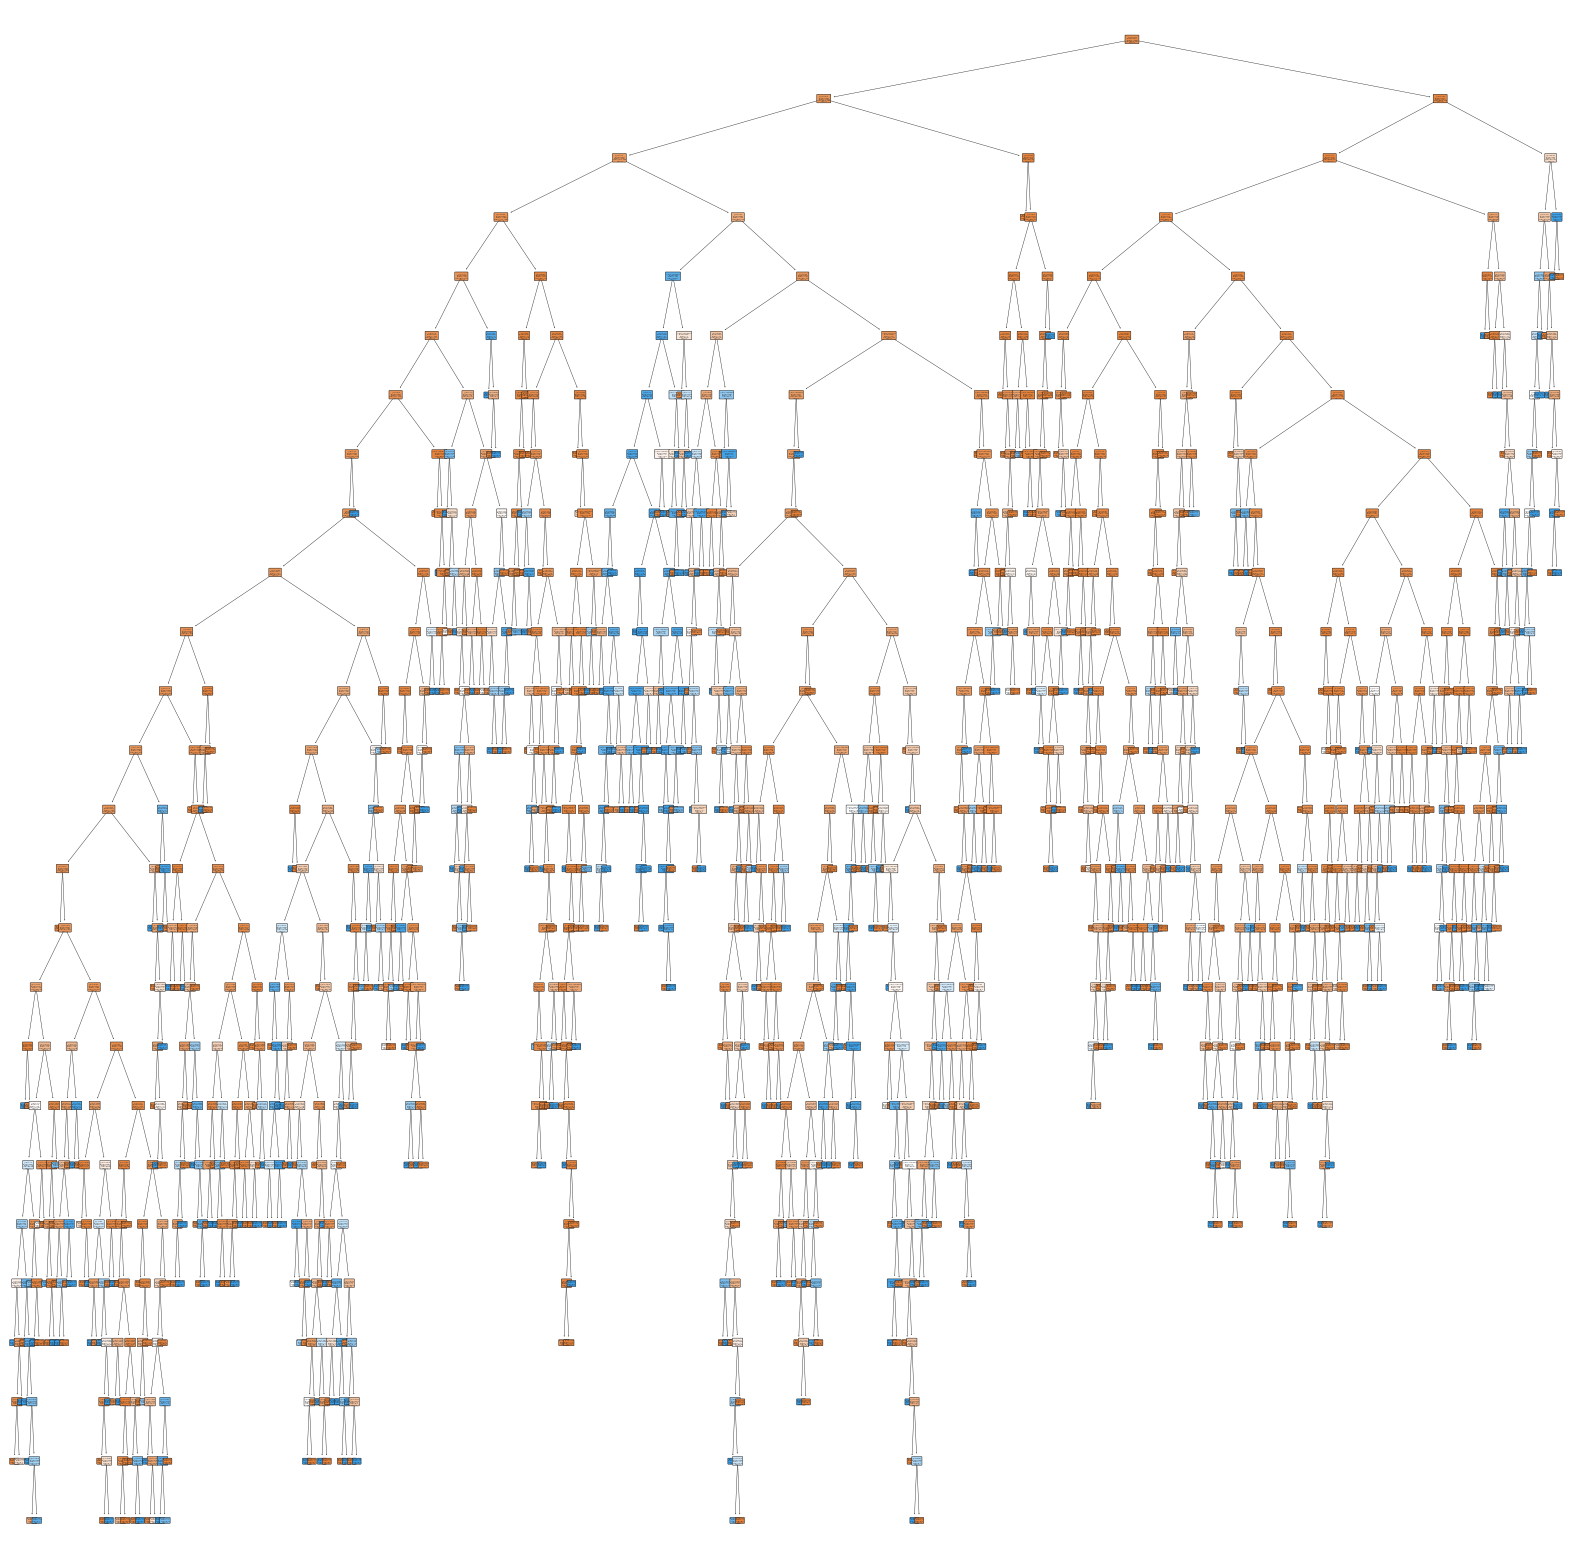

In [53]:
# c4.5

from sklearn import tree
# picture
fn=list(X_train.columns)
cn = ['0', '1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), )
tree.plot_tree(clf,
               rounded=True,
               feature_names = fn,
               class_names=cn,
               filled = True)
plt.savefig('D:/ssd/dt.png')
plt.show()


In [54]:
from sklearn.tree import _tree

def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]
    rules = []
    values = tree_.value.tolist()

    def recurse(node, depth, rule):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left_branch = tree_.children_left[node]
            right_branch = tree_.children_right[node]

            rule_left = list(rule)
            rule_left.append((name, '<=', threshold))
            recurse(left_branch, depth + 1, rule_left)

            rule_right = list(rule)
            rule_right.append((name, '>', threshold))
            recurse(right_branch, depth + 1, rule_right)
        else:
            class_ = values[node][0]
            if class_[0] > class_[1]:
                rules.append((rule, 0))
            else:
                rules.append((rule, 1))
        
    recurse(0, 1, [])
    return rules

rules = tree_to_rules(clf, fn)
failed_rules = []

for rule in rules:
    if rule[1] == 1:
        failed_rules.append(rule)

In [55]:
dt_rules = [{'rule': r[0], 'label': '1', 'alg': 'dt'} for r in failed_rules]

print(f"number of dt rules: {len(dt_rules)}")
print(dt_rules)

number of dt rules: 299
[{'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 87.5), ('n_173', '<=', 1.5), ('r_9', '<=', 37469.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 35.5), ('r_196', '<=', 3.0), ('r_9', '<=', 27802.0), ('r_9', '<=', 13396.5), ('r_12', '<=', 25.5), ('n_194', '<=', 71.5), ('r_180', '<=', 6591.0), ('r_12', '<=', 23.5), ('r_9', '>', 4248.5), ('n_194', '<=', 68.5), ('r_9', '<=', 11213.5), ('n_183', '<=', 99.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 87.5), ('n_173', '<=', 1.5), ('r_9', '<=', 37469.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 35.5), ('r_196', '<=', 3.0), ('r_9', '<=', 27802.0), ('r_9', '<=', 13396.5), ('r_12', '<=', 25.5), ('n_194', '<=', 71.5), ('r_180', '<=', 6591.0), ('r_12', '<=', 23.5), ('r_9', '>', 4248.5), ('n_194', '<=', 68.5), ('r_9', '>', 11213.5), ('r_9', '<=', 12361.5), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '<=', 11656.5), ('r_12', '<=', 15.5)], 'label': '

In [56]:
# jrip

jrip_rules = []
with open("D:\ssd\weka\jrip-py.txt") as f:
    for line in f:
        if '=>' not in line:
            print(f"error! {line}")
            break
            
        split_line = line.split(' => ')
        label = '1' if 'yes' in split_line[1] else '0'
        rule = split_line[0].split(' and ')
        transfer_rule = []
        for r in rule:
            if not r:
                continue
            tmp = r[1:-1].split(' ')
            transfer_rule.append((tmp[0], tmp[1], float(tmp[2])))
        if transfer_rule:
            jrip_rules.append({'rule': transfer_rule, 'label': label, 'alg': 'jrip'})
f.close()

print(f"number of jrip rules: {len(jrip_rules)}")
print(jrip_rules)
    

number of jrip rules: 115
[{'rule': [('r_180', '>=', 6484.0), ('n_173', '>=', 2.0), ('r_195', '<=', 1222842641.0), ('n_173', '<=', 2.0), ('r_12', '<=', 33.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('r_180', '>=', 6466.0), ('n_173', '>=', 2.0), ('r_195', '<=', 2345869567.0), ('r_9', '>=', 38895.0), ('r_195', '>=', 1292387876.0), ('n_173', '<=', 2.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('r_180', '>=', 6458.0), ('n_173', '>=', 2.0), ('n_173', '<=', 3.0), ('r_195', '<=', 1381148196.0), ('r_12', '>=', 40.0), ('r_195', '>=', 1174268997.0), ('r_12', '<=', 49.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('n_170', '<=', 99.0), ('n_173', '>=', 2.0), ('r_195', '<=', 1292222518.0), ('n_173', '<=', 2.0), ('r_9', '>=', 38015.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('n_170', '<=', 99.0), ('n_173', '>=', 2.0), ('n_173', '<=', 3.0), ('r_12', '<=', 30.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('n_170', '<=', 99.0), ('n_173', '>=', 2.0), ('n_173', '<=', 3.0), ('r_5', '>=', 1.0), ('r_9', 

In [57]:
# part

part_rules = []

rule = []
label = ''

with open("D:\ssd\weka\part-py.txt") as f:
    for line in f:
        line = line.strip() 
        
        if not line:
            continue
            
        elif ':' in line:
            line_split = line.split(':')
            label = '1' if 'yes' in line_split[1] else '0'
            
            tmp = line_split[0].split(' ')
            rule.append((tmp[0], tmp[1], float(tmp[2])))
            part_rules.append({'rule': rule, 'label': label, 'alg': 'part'})
            rule = []
            
                
        else:
            if line and 'AND' not in line:
                print(f"error! {line}")
            line_split = line[:-4].split(' ')
            rule.append((line_split[0], line_split[1], float(line_split[2])))
        
f.close()


print(f"number of part rules: {len(part_rules)}")
print(part_rules)
    

number of part rules: 466
[{'rule': [('n_170', '>', 99.0), ('r_183', '<=', 275.0), ('r_9', '>', 2362.0), ('r_199', '<=', 150.0), ('r_174', '<=', 69.0), ('r_9', '>', 23575.0), ('n_5', '>', 98.0), ('r_174', '<=', 9.0), ('r_174', '>', 3.0), ('r_199', '<=', 1.0), ('r_183', '<=', 3.0), ('r_9', '>', 31665.0), ('r_194', '>', 22.0), ('r_12', '>', 11.0)], 'label': '0', 'alg': 'part'}, {'rule': [('n_170', '>', 99.0), ('r_183', '<=', 275.0), ('r_9', '>', 2362.0), ('r_199', '<=', 150.0), ('r_174', '<=', 69.0), ('r_9', '>', 23575.0), ('r_9', '>', 24460.0), ('n_5', '>', 98.0), ('r_9', '<=', 39145.0), ('r_12', '>', 25.0), ('r_199', '<=', 131.0), ('r_174', '<=', 37.0)], 'label': '0', 'alg': 'part'}, {'rule': [('n_170', '>', 99.0), ('r_183', '<=', 275.0), ('r_9', '>', 2362.0), ('r_199', '<=', 150.0), ('r_12', '<=', 24.0), ('r_9', '>', 26141.0), ('r_199', '<=', 104.0), ('r_199', '<=', 103.0), ('r_199', '<=', 73.0), ('r_199', '<=', 72.0), ('r_9', '>', 27324.0), ('r_199', '>', 1.0), ('r_9', '>', 27664.0)]

## Reduplication and simplification rule sets

In [58]:
# reduplication and simplification

all_rules = dt_rules + jrip_rules + part_rules
for raw_rule in all_rules:
    rule = raw_rule['rule']
    crt_dict = {}
    for r in rule:
        if r[0] not in crt_dict.keys():
            crt_dict[r[0]] = {'op': r[1], 'value': r[2]}
        else:
                    
            if r[1] == '>=' and crt_dict[r[0]]['op'] == '>=':
                crt_dict[r[0]]['value'] = max(r[2], crt_dict[r[0]]['value'])
            elif r[1] == '>' and crt_dict[r[0]]['op'] == '>':
                crt_dict[r[0]]['value'] = max(r[2], crt_dict[r[0]]['value'])
            elif r[1] == '<=' and crt_dict[r[0]]['op'] == '<=':
                crt_dict[r[0]]['value'] = min(r[2], crt_dict[r[0]]['value'])
            elif r[1] == '<' and crt_dict[r[0]]['op'] == '<':
                crt_dict[r[0]]['value'] = min(r[2], crt_dict[r[0]]['value'])
            elif r[1] == '>=' and crt_dict[r[0]]['op'] == '>':
                if r[2] > crt_dict[r[0]]['value']:
                    crt_dict[r[0]] = {'op': r[1], 'value': r[2]}
            elif r[1] == '>' and crt_dict[r[0]]['op'] == '>=':
                if r[2] > crt_dict[r[0]]['value']:
                    crt_dict[r[0]] = {'op': r[1], 'value': r[2]}
            elif r[1] == '<=' and crt_dict[r[0]]['op'] == '<':
                if r[2] < crt_dict[r[0]]['value']:
                    crt_dict[r[0]] = {'op': r[1], 'value': r[2]}
            elif r[1] == '<' and crt_dict[r[0]]['op'] == '<=':
                if r[2] < crt_dict[r[0]]['value']:
                    crt_dict[r[0]] = {'op': r[1], 'value': r[2]}
                
    crt_rule = []
    for k, v in crt_dict.items():
        crt_rule.append((k, v['op'], v['value']))
        
    for r in rule:
        if r[0] in crt_dict.keys() and r[1] != crt_dict[r[0]]['op']:
            crt_rule.append(r)
            
    raw_rule['rule'] = crt_rule 


In [59]:
new_dt_rules, new_jrip_rules, new_part_rules = [], [], []
for rule in all_rules:
    if rule['alg'] == 'dt':
        new_dt_rules.append(rule)
    elif rule['alg'] == 'jrip':
        new_jrip_rules.append(rule)
    elif rule['alg'] == 'part':
        new_part_rules.append(rule)

In [60]:
## after simplification

print(f"number of new dt rules: {len(new_dt_rules)}")
print(new_dt_rules)

number of new dt rules: 299
[{'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11213.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 23.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('n_183', '<=', 99.5), ('r_9', '>', 4248.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11656.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 15.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '>', 4248.5), ('r_9', '>', 11213.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11656.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 23.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '>', 4248.5), ('r_9', '>', 11213.5), ('r_12', '>', 15.5), ('r_12', '>', 18.5)], 

In [61]:
print(f"number of new jrip rules: {len(new_jrip_rules)}")
print(new_jrip_rules)

number of new jrip rules: 115
[{'rule': [('r_180', '>=', 6484.0), ('n_173', '>=', 2.0), ('r_195', '<=', 1222842641.0), ('r_12', '<=', 33.0), ('n_173', '<=', 2.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('r_180', '>=', 6466.0), ('n_173', '>=', 2.0), ('r_195', '<=', 2345869567.0), ('r_9', '>=', 38895.0), ('r_195', '>=', 1292387876.0), ('n_173', '<=', 2.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('r_180', '>=', 6458.0), ('n_173', '>=', 2.0), ('r_195', '<=', 1381148196.0), ('r_12', '>=', 40.0), ('n_173', '<=', 3.0), ('r_195', '>=', 1174268997.0), ('r_12', '<=', 49.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('n_170', '<=', 99.0), ('n_173', '>=', 2.0), ('r_195', '<=', 1292222518.0), ('r_9', '>=', 38015.0), ('n_173', '<=', 2.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('n_170', '<=', 99.0), ('n_173', '>=', 2.0), ('r_12', '<=', 30.0), ('n_173', '<=', 3.0)], 'label': '1', 'alg': 'jrip'}, {'rule': [('n_170', '<=', 99.0), ('n_173', '>=', 2.0), ('r_5', '>=', 1.0), ('r_9', '>=', 38727.0), ('

In [62]:
print(f"number of new part rules: {len(new_part_rules)}")
print(new_part_rules)

number of new part rules: 466
[{'rule': [('n_170', '>', 99.0), ('r_183', '<=', 3.0), ('r_9', '>', 31665.0), ('r_199', '<=', 1.0), ('r_174', '<=', 9.0), ('n_5', '>', 98.0), ('r_194', '>', 22.0), ('r_12', '>', 11.0), ('r_174', '>', 3.0)], 'label': '0', 'alg': 'part'}, {'rule': [('n_170', '>', 99.0), ('r_183', '<=', 275.0), ('r_9', '>', 24460.0), ('r_199', '<=', 131.0), ('r_174', '<=', 37.0), ('n_5', '>', 98.0), ('r_12', '>', 25.0), ('r_9', '<=', 39145.0)], 'label': '0', 'alg': 'part'}, {'rule': [('n_170', '>', 99.0), ('r_183', '<=', 275.0), ('r_9', '>', 27664.0), ('r_199', '<=', 72.0), ('r_12', '<=', 24.0), ('r_199', '>', 1.0)], 'label': '0', 'alg': 'part'}, {'rule': [('r_195', '<=', 500417326.0), ('r_199', '<=', 143.0), ('n_170', '>', 99.0), ('r_174', '<=', 18.0), ('r_9', '>', 27696.0), ('r_183', '<=', 3.0), ('r_194', '>', 25.0), ('r_12', '>', 13.0), ('r_174', '>', 6.0), ('r_174', '>', 8.0), ('r_12', '<=', 19.0), ('r_9', '<=', 39385.0)], 'label': '0', 'alg': 'part'}, {'rule': [('r_195',

In [63]:
print(len(all_rules))
print(all_rules)

880
[{'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11213.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 23.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('n_183', '<=', 99.5), ('r_9', '>', 4248.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11656.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 15.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '>', 4248.5), ('r_9', '>', 11213.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11656.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 23.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '>', 4248.5), ('r_9', '>', 11213.5), ('r_12', '>', 15.5), ('r_12', '>', 18.5)], 'label': '1', 'alg': 'dt

## Calculate the coverage and precision of each rule in the rule sets

In [65]:
#  coverage，precison of each rule
import re
trigger_dict = {}
rule_index = 0

for rule in all_rules:
    print(rule_index)
    rule = rule['rule']
    trigger_dict[rule_index] = []
    feature, op, value = [], [], []
    for r in rule:
        feature.append(r[0])
        op.append(r[1])
        value.append(r[2])
    for index, row in df_use.iterrows():
        trigger = True
        for i in range(len(feature)):
            if op[i] == '>=':
                if not row[feature[i]] >= value[i]:
                    trigger = False
            elif op[i] == '>':
                if not row[feature[i]] > value[i]:
                    trigger = False
            elif op[i] == '==':
                if not row[feature[i]] == value[i]:
                    trigger = False
            elif op[i] == '<=':
                if not row[feature[i]] <= value[i]:
                    trigger = False
            elif op[i] == '<':
                if not row[feature[i]] < value[i]:
                    trigger = False
        if trigger:
            trigger_dict[rule_index].append(index)
            
    rule_index += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [68]:
# failed number in all data set
df_use['label'].value_counts()
total_failed = 6090

In [69]:
info_dict = {}
for key, row_index in trigger_dict.items():
    cnt = 0
    if len(row_index):
        for idx in row_index:
            if df_use.loc[idx]['label'] == 'yes':
                cnt += 1
        info_dict[key] = (cnt / total_failed, cnt / len(row_index))

for key, c in info_dict.items():
    print(c)
    

(0.0003284072249589491, 1.0)
(0.004433497536945813, 0.9310344827586207)
(0.0006568144499178982, 0.8)
(0.010016420361247948, 0.9682539682539683)
(0.0019704433497536944, 1.0)
(0.003940886699507389, 0.8275862068965517)
(0.0009852216748768472, 0.75)
(0.00016420361247947455, 1.0)
(0.0006568144499178982, 0.5714285714285714)
(0.0019704433497536944, 0.8571428571428571)
(0.0004926108374384236, 1.0)
(0.0011494252873563218, 0.875)
(0.004105090311986864, 1.0)
(0.004597701149425287, 1.0)
(0.008374384236453201, 1.0)
(0.00016420361247947455, 0.3333333333333333)
(0.0003284072249589491, 1.0)
(0.0064039408866995075, 1.0)
(0.0008210180623973727, 1.0)
(0.004597701149425287, 1.0)
(0.0006568144499178982, 1.0)
(0.0013136288998357964, 0.8)
(0.0011494252873563218, 1.0)
(0.0006568144499178982, 0.5)
(0.002955665024630542, 1.0)
(0.00541871921182266, 1.0)
(0.004597701149425287, 0.7567567567567568)
(0.003284072249589491, 1.0)
(0.0024630541871921183, 0.9375)
(0.004761904761904762, 1.0)
(0.0049261083743842365, 0.9375

In [70]:
print(all_rules)

[{'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11213.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 23.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('n_183', '<=', 99.5), ('r_9', '>', 4248.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11656.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 15.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '>', 4248.5), ('r_9', '>', 11213.5)], 'label': '1', 'alg': 'dt'}, {'rule': [('n_170', '<=', 99.5), ('n_173', '<=', 1.5), ('r_9', '<=', 11656.5), ('r_171', '<=', 8.0), ('r_199', '<=', 0.5), ('r_12', '<=', 23.5), ('r_196', '<=', 3.0), ('n_194', '<=', 68.5), ('r_180', '<=', 6591.0), ('r_194', '<=', 37.5), ('r_183', '<=', 1.0), ('r_9', '>', 4248.5), ('r_9', '>', 11213.5), ('r_12', '>', 15.5), ('r_12', '>', 18.5)], 'label': '1', 'alg': 'dt'}, 

In [71]:
print(info_dict)

{0: (0.0003284072249589491, 1.0), 1: (0.004433497536945813, 0.9310344827586207), 2: (0.0006568144499178982, 0.8), 3: (0.010016420361247948, 0.9682539682539683), 4: (0.0019704433497536944, 1.0), 5: (0.003940886699507389, 0.8275862068965517), 6: (0.0009852216748768472, 0.75), 7: (0.00016420361247947455, 1.0), 8: (0.0006568144499178982, 0.5714285714285714), 9: (0.0019704433497536944, 0.8571428571428571), 10: (0.0004926108374384236, 1.0), 11: (0.0011494252873563218, 0.875), 12: (0.004105090311986864, 1.0), 13: (0.004597701149425287, 1.0), 14: (0.008374384236453201, 1.0), 15: (0.00016420361247947455, 0.3333333333333333), 16: (0.0003284072249589491, 1.0), 17: (0.0064039408866995075, 1.0), 18: (0.0008210180623973727, 1.0), 19: (0.004597701149425287, 1.0), 20: (0.0006568144499178982, 1.0), 21: (0.0013136288998357964, 0.8), 22: (0.0011494252873563218, 1.0), 23: (0.0006568144499178982, 0.5), 24: (0.002955665024630542, 1.0), 25: (0.00541871921182266, 1.0), 26: (0.004597701149425287, 0.75675675675

## rule selection filter:
- coverage
- precision
- number of features in a rule

In [99]:
# first of all， filter rules which precision > 0.9, number of features in a rule < 15
length= {}
for r in all_rules:
    # number of features in rule
    if len(r['rule']) not in length.keys():
        length[len(r['rule'])] = 1
    else:
        length[len(r['rule'])] += 1
print(length)

{11: 46, 13: 57, 15: 29, 16: 19, 18: 6, 12: 55, 14: 43, 17: 5, 10: 49, 8: 48, 9: 45, 7: 59, 6: 95, 5: 90, 20: 2, 21: 1, 23: 1, 4: 92, 2: 49, 3: 80, 19: 1, 1: 8}


In [76]:
# first of all， filter rules which precision > 0.9, number of features in a rule < 15
# then, sort the coverage in descending order

filter_dict = [{'index': k, 'corr': v[0], 'precision': v[1]} for k, v in info_dict.items() if v[1] > 0.9 and len(all_rules[k]['rule']) <= 14 ]
print(len(filter_dict))
print(filter_dict)


322
[{'index': 0, 'corr': 0.0003284072249589491, 'precision': 1.0}, {'index': 1, 'corr': 0.004433497536945813, 'precision': 0.9310344827586207}, {'index': 7, 'corr': 0.00016420361247947455, 'precision': 1.0}, {'index': 10, 'corr': 0.0004926108374384236, 'precision': 1.0}, {'index': 12, 'corr': 0.004105090311986864, 'precision': 1.0}, {'index': 13, 'corr': 0.004597701149425287, 'precision': 1.0}, {'index': 14, 'corr': 0.008374384236453201, 'precision': 1.0}, {'index': 16, 'corr': 0.0003284072249589491, 'precision': 1.0}, {'index': 17, 'corr': 0.0064039408866995075, 'precision': 1.0}, {'index': 27, 'corr': 0.003284072249589491, 'precision': 1.0}, {'index': 28, 'corr': 0.0024630541871921183, 'precision': 0.9375}, {'index': 29, 'corr': 0.004761904761904762, 'precision': 1.0}, {'index': 30, 'corr': 0.0049261083743842365, 'precision': 0.9375}, {'index': 31, 'corr': 0.0003284072249589491, 'precision': 1.0}, {'index': 32, 'corr': 0.0006568144499178982, 'precision': 1.0}, {'index': 33, 'corr': 

In [77]:
# remaining rules: 303

filter_dict = sorted(filter_dict, key=lambda x: x['corr'], reverse=True)
print(filter_dict)

[{'index': 303, 'corr': 0.0651888341543514, 'precision': 0.9543269230769231}, {'index': 601, 'corr': 0.05238095238095238, 'precision': 0.9937694704049844}, {'index': 307, 'corr': 0.04729064039408867, 'precision': 0.9664429530201343}, {'index': 127, 'corr': 0.04400656814449918, 'precision': 1.0}, {'index': 300, 'corr': 0.03973727422003284, 'precision': 1.0}, {'index': 124, 'corr': 0.03661740558292283, 'precision': 1.0}, {'index': 299, 'corr': 0.035467980295566505, 'precision': 1.0}, {'index': 302, 'corr': 0.035467980295566505, 'precision': 0.9863013698630136}, {'index': 304, 'corr': 0.035139573070607555, 'precision': 1.0}, {'index': 600, 'corr': 0.03185550082101806, 'precision': 0.9847715736040609}, {'index': 319, 'corr': 0.02857142857142857, 'precision': 0.9830508474576272}, {'index': 312, 'corr': 0.02528735632183908, 'precision': 0.9746835443037974}, {'index': 321, 'corr': 0.02348111658456486, 'precision': 0.9862068965517241}, {'index': 631, 'corr': 0.022988505747126436, 'precision': 

In [75]:
df_use['label'] = df_use.label.replace(to_replace=['no', 'yes'], value=[0, 1])
df_use

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,n_195,r_195,n_196,r_196,r_197,r_198,n_199,r_199,r_206,label
0,406,2018-10-01,MA1,130.0,4.137765e+09,98.0,0.0,100.0,35996.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
1,406,2018-10-02,MA1,130.0,4.175147e+09,98.0,0.0,100.0,36019.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,406,2018-10-03,MA1,130.0,4.215511e+09,98.0,0.0,100.0,36043.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,406,2018-10-04,MA1,130.0,4.254417e+09,98.0,0.0,100.0,36067.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
4,406,2018-10-05,MA1,130.0,4.293503e+09,98.0,0.0,100.0,36091.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72709,19055,2018-12-28,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13259.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0
72710,19055,2018-12-29,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13283.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0
72711,19055,2018-12-30,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13307.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0
72712,19055,2018-12-31,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13331.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0


In [78]:
# compute rule avg importance： sum of feature shap / number of features

rule_weight = {}

for i in range(303):
    idx = filter_dict[i]['index']
    rule = all_rules[idx]['rule']
    sum_shap = 0
    for f in rule:
        sum_shap += shap_dict[f[0]]
        
    rule_weight[idx] = sum_shap / len(rule)

print(len(rule_weight))
print(rule_weight)

303
{303: 0.04925022410033567, 601: 0.03292057536068723, 307: 0.04746642859610084, 127: 0.02858569047549478, 300: 0.04390741640477519, 124: 0.029485415756519286, 299: 0.03848341942380247, 302: 0.053605659542196295, 304: 0.05311444055139487, 600: 0.022498906011965143, 319: 0.029726247713392467, 312: 0.04469891950998303, 321: 0.03047042158392982, 631: 0.030217791398587452, 301: 0.027918316901328642, 756: 0.04465030469069631, 306: 0.04242326721480672, 135: 0.03601943160340177, 364: 0.051583582818965, 372: 0.05211971931745594, 837: 0.041159827936541424, 52: 0.026461146441640573, 149: 0.051046642314020056, 308: 0.022245357037531156, 120: 0.03779429504598993, 793: 0.03472405545116053, 378: 0.01855214090932779, 48: 0.0294824540164085, 334: 0.043826507050375135, 132: 0.0360066704931625, 389: 0.03340438555850272, 69: 0.027829788613503752, 298: 0.04105113293901405, 339: 0.035963364589010526, 305: 0.02532647213975688, 320: 0.04208818190324988, 340: 0.042423267214806715, 297: 0.0409261352772942, 1

In [86]:
# check a record without missing value will trigger a rule

op_list = ['>=', '>', '==', '<', '<=']
def trigger_rule_without_missing(rule, row):
    # without missing value，check if trigger
    trigger = True
    for feature in rule:
        if feature[1] == '>=':
            trigger = row[feature[0]] >= feature[2]
        elif feature[1] == '>':
            trigger = row[feature[0]] > feature[2]
        elif feature[1] == '==':
            trigger = row[feature[0]] == feature[2]
        elif feature[1] == '<':
            trigger = row[feature[0]] < feature[2]
        elif feature[1] == '<=':
            trigger = row[feature[0]] <= feature[2]
        if not trigger:
            break
    return trigger

## rules selection
-  after filtering the rules, arrange them in order of coverage and select the top 30 rules
- sort this set of rules based on their avg importance (rule weight)
- test the performance of this set of rule sets
- select 40, 50 in sequence Until 300 pieces, repeat the above steps

In [113]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

def get_select_rule_rank(rule_set):
    # get the importance(weight) sorting for rule set
    weight_rank = {}
    for rule in rule_set:
        print(rule['index'], rule_weight[rule['index']])
        weight_rank[rule['index']] = rule_weight[rule['index']]
    print(weight_rank)
    weight_rank = sorted(weight_rank.items(), key=lambda x: x, reverse = True)
    return weight_rank
    
def get_select_rule_info(rule_set):
    # get infomation of rule set
    rule_info = {'dt': 0, 'jrip': 0, 'part': 0}
    for rule in rule_set:
        source = all_rules[rule['index']]['alg']
        rule_info[source] += 1
    return rule_info

op_list = ['>=', '>', '==', '<', '<=']
def trigger_rule_without_missing(rule, row):
    # row without missing value, check if trigger rule
    trigger = True
    for feature in rule:
        if feature[1] == '>=':
            trigger = row[feature[0]] >= feature[2]
        elif feature[1] == '>':
            trigger = row[feature[0]] > feature[2]
        elif feature[1] == '==':
            trigger = row[feature[0]] == feature[2]
        elif feature[1] == '<':
            trigger = row[feature[0]] < feature[2]
        elif feature[1] == '<=':
            trigger = row[feature[0]] <= feature[2]
        if not trigger:
            break
    return trigger

def get_pred_label(rule_set_rank):
    # make prediction
    # for row in df, check whether triggers will occur in descending order of rule importance(weight)

    y_pred = []
    op_list = ['>=', '>', '==', '<', '<=']
    
    for index , row in df_use.iterrows():
        
        trigger = False
        for idx_weight in rule_set_rank:
            # descending order of rule importance(weight)
            idx, weight = idx_weight[0], idx_weight[1]
            rule = all_rules[idx]['rule']
            trigger = trigger_rule_without_missing(rule, row)
            if trigger: # if trigger, labeled as failed
                break
        if trigger:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

        
rule_nums = range(30, 310, 10)
rule_set_records = {}
for num in rule_nums:
    print(f"=====num = {num}====")
    rule_set = filter_dict[: num]
    
    rule_set_rank = get_select_rule_rank(rule_set)
    print("weight rank:")
    print(rule_set_rank)
    
    rule_set_info = get_select_rule_info(rule_set)
    print("rule info:")
    print(rule_set_info)
    
    y_pred_label = get_pred_label(rule_set_rank)
    recall = recall_score(df_use['label'], y_pred_label)
    precison = precision_score(df_use['label'], y_pred_label)
#     accuracy_score = accuracy_score(df_use['label'], y_pred_label)
    print("metrics:")
    print(recall)
    print(precison)
#     print(accuracy_score)
    
    rule_set_records[num] = dict(
        rule_info=rule_set_info,
        recall=recall,
        precison=precison,
        y_pred_label=y_pred_label
    )

print(rule_set_records)


=====num = 30====
303 0.05058924143926571
601 0.034159917245048424
307 0.04876340853340458
127 0.02812027105718864
300 0.04471510439198668
124 0.030518737698588115
299 0.039086088255972186
302 0.05504343016582439
304 0.05454864693516119
600 0.02335143272894822
319 0.030954882143193578
312 0.04611067268105367
321 0.03259173789394688
631 0.0312484100163902
301 0.02856305203158852
756 0.0463939932686345
306 0.043871388301947645
135 0.041068493515408956
364 0.05272188724820056
372 0.05304531773357228
837 0.04281539021820602
52 0.02756476054993182
149 0.052238770021876345
308 0.023103566862397933
120 0.03945377661593363
793 0.03527074113411143
378 0.020871371924257743
48 0.030693387281929236
334 0.04459091419641712
132 0.03734166097668974
{303: 0.05058924143926571, 601: 0.034159917245048424, 307: 0.04876340853340458, 127: 0.02812027105718864, 300: 0.04471510439198668, 124: 0.030518737698588115, 299: 0.039086088255972186, 302: 0.05504343016582439, 304: 0.05454864693516119, 600: 0.02335143272

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [114]:
rule_info_list = {n: rule_set_records[n]['rule_info'] for n in rule_nums}
print(rule_info_list)

{30: {'dt': 8, 'jrip': 16, 'part': 6}, 40: {'dt': 12, 'jrip': 22, 'part': 6}, 50: {'dt': 14, 'jrip': 30, 'part': 6}, 60: {'dt': 20, 'jrip': 33, 'part': 7}, 70: {'dt': 22, 'jrip': 41, 'part': 7}, 80: {'dt': 26, 'jrip': 47, 'part': 7}, 90: {'dt': 30, 'jrip': 53, 'part': 7}, 100: {'dt': 38, 'jrip': 55, 'part': 7}, 110: {'dt': 43, 'jrip': 60, 'part': 7}, 120: {'dt': 47, 'jrip': 64, 'part': 9}, 130: {'dt': 51, 'jrip': 70, 'part': 9}, 140: {'dt': 57, 'jrip': 73, 'part': 10}, 150: {'dt': 63, 'jrip': 76, 'part': 11}, 160: {'dt': 65, 'jrip': 83, 'part': 12}, 170: {'dt': 71, 'jrip': 86, 'part': 13}, 180: {'dt': 75, 'jrip': 92, 'part': 13}, 190: {'dt': 81, 'jrip': 96, 'part': 13}, 200: {'dt': 88, 'jrip': 99, 'part': 13}, 210: {'dt': 97, 'jrip': 100, 'part': 13}, 220: {'dt': 102, 'jrip': 105, 'part': 13}, 230: {'dt': 112, 'jrip': 105, 'part': 13}, 240: {'dt': 121, 'jrip': 106, 'part': 13}, 250: {'dt': 130, 'jrip': 107, 'part': 13}, 260: {'dt': 139, 'jrip': 108, 'part': 13}, 270: {'dt': 149, 'jrip'

### table of infomation about different sizes rule sets

In [164]:
df_data = []
idx = 0
for k, v in rule_set_records.items():
    tmp = [k, v['rule_info']['dt'], v['rule_info']['jrip'], v['rule_info']['part'], round(acc_list[idx], 4), round(v['precison'], 4), round(v['recall'], 4)]
    df_data.append(tmp)

df_data = pd.DataFrame(df_data, columns=['number of rules', 'from C4.5', 'from JRIP', 'from PART', 'accuracy', 'precision', 'recall'])
df_data

,number of rules,from C4.5,from JRIP,from PART,accuracy,precision,recall
0,30,8,16,6,0.9395,0.9639,0.2890
1,40,12,22,6,0.9395,0.9656,0.3593
2,50,14,30,6,0.9395,0.9679,0.4259
3,60,20,33,7,0.9395,0.9698,0.4594
4,70,22,41,7,0.9395,0.9699,0.5020
5,80,26,47,7,0.9395,0.9706,0.5420
6,90,30,53,7,0.9395,0.9716,0.5677
7,100,38,55,7,0.9395,0.9714,0.5906
8,110,43,60,7,0.9395,0.9720,0.6100
9,120,47,64,9,0.9395,0.9726,0.6294


In [165]:
df_data.to_csv('D:/ssd/ruleSelection.csv',index=None)

## performance of different sizes of rule sets

In [115]:
precision_list = [rule_set_records[n]['precison'] for n in rule_nums]
recall_list = [rule_set_records[n]['recall'] for n in rule_nums]
acc_list = []
for n in rule_nums:
    acc = accuracy_score(df_use['label'], rule_set_records[n]['y_pred_label'])
    acc_list.append(acc)

print(precision_list)
print(recall_list)
print(acc_list)

[0.963855421686747, 0.9655781112091791, 0.9679104477611941, 0.9698440207972271, 0.9698604060913706, 0.9705968832696266, 0.9716132658797078, 0.9713745611666217, 0.9720041862899006, 0.9725957878710987, 0.9726855209088712, 0.9725426857406553, 0.9727556945064761, 0.9729375818419904, 0.972961373390558, 0.9730639730639731, 0.973549313102317, 0.9736418511066398, 0.9732249107497025, 0.9736383019965109, 0.9737492866653985, 0.9735049205147616, 0.9733932921116732, 0.9734792284866469, 0.973621103117506, 0.9737470167064439, 0.9738526238800512, 0.9739051094890511]
[0.2889983579638752, 0.3592775041050903, 0.425944170771757, 0.4594417077175698, 0.5019704433497537, 0.5420361247947455, 0.5676518883415436, 0.59064039408867, 0.6100164203612479, 0.629392446633826, 0.6607553366174056, 0.6921182266009852, 0.7152709359605911, 0.7320197044334975, 0.7444991789819376, 0.7592775041050903, 0.7796387520525452, 0.7945812807881774, 0.8057471264367816, 0.8247947454844007, 0.8405582922824302, 0.8446633825944171, 0.8530

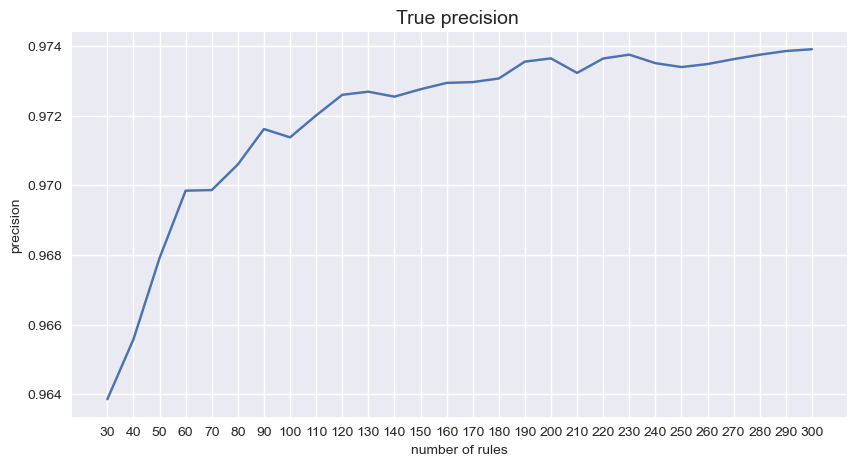

In [120]:
plt.figure(figsize=(10, 5))
plt.plot(rule_nums, precision_list)
plt.title('True precision ', fontsize=14)
plt.xlabel('number of rules')
plt.ylabel('precision')
plt.xticks(rule_nums)
plt.show()


In [125]:
precision_list

[0.963855421686747,
 0.9655781112091791,
 0.9679104477611941,
 0.9698440207972271,
 0.9698604060913706,
 0.9705968832696266,
 0.9716132658797078,
 0.9713745611666217,
 0.9720041862899006,
 0.9725957878710987,
 0.9726855209088712,
 0.9725426857406553,
 0.9727556945064761,
 0.9729375818419904,
 0.972961373390558,
 0.9730639730639731,
 0.973549313102317,
 0.9736418511066398,
 0.9732249107497025,
 0.9736383019965109,
 0.9737492866653985,
 0.9735049205147616,
 0.9733932921116732,
 0.9734792284866469,
 0.973621103117506,
 0.9737470167064439,
 0.9738526238800512,
 0.9739051094890511]

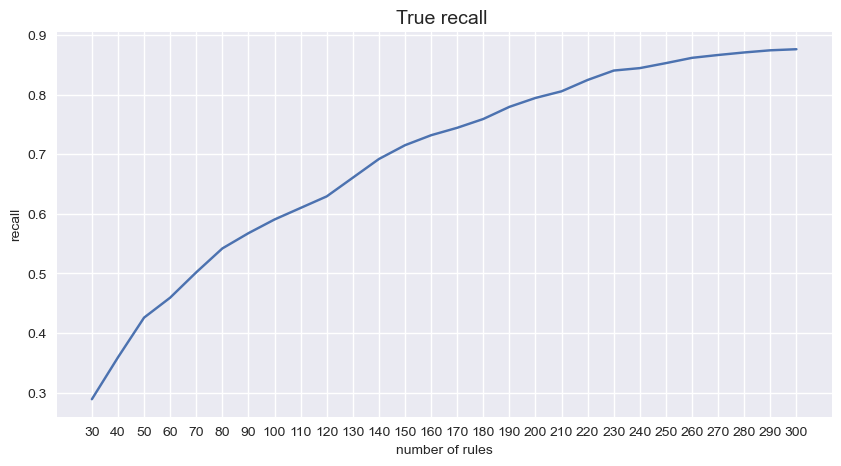

In [121]:
plt.figure(figsize=(10, 5))
plt.plot(rule_nums, recall_list)
plt.title('True recall ', fontsize=14)
plt.xlabel('number of rules')
plt.ylabel('recall')
plt.xticks(rule_nums)
plt.show()


In [126]:
recall_list

[0.2889983579638752,
 0.3592775041050903,
 0.425944170771757,
 0.4594417077175698,
 0.5019704433497537,
 0.5420361247947455,
 0.5676518883415436,
 0.59064039408867,
 0.6100164203612479,
 0.629392446633826,
 0.6607553366174056,
 0.6921182266009852,
 0.7152709359605911,
 0.7320197044334975,
 0.7444991789819376,
 0.7592775041050903,
 0.7796387520525452,
 0.7945812807881774,
 0.8057471264367816,
 0.8247947454844007,
 0.8405582922824302,
 0.8446633825944171,
 0.8530377668308703,
 0.861904761904762,
 0.8666666666666667,
 0.870935960591133,
 0.8745484400656814,
 0.8763546798029557]

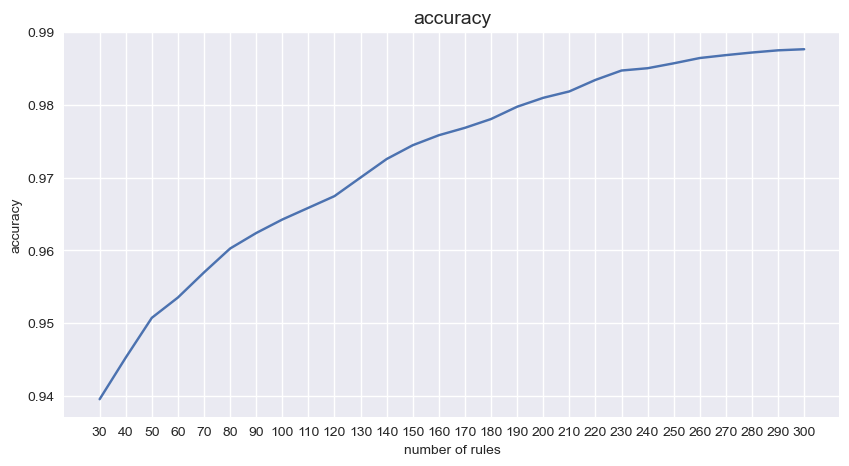

In [122]:
plt.figure(figsize=(10, 5))
plt.plot(rule_nums, acc_list)
plt.title('accuracy', fontsize=14)
plt.xlabel('number of rules')
plt.ylabel('accuracy')
plt.xticks(rule_nums)
plt.show()


In [127]:
acc_list

[0.9395439667739363,
 0.9452650108644828,
 0.9507385097780345,
 0.9535302692741425,
 0.9569821492422367,
 0.9602689990923343,
 0.9624006381164563,
 0.9642572269439172,
 0.9658662705943835,
 0.9674753142448497,
 0.9700332810737959,
 0.9725774953929092,
 0.9744753417498694,
 0.9758505927331738,
 0.9768682784608191,
 0.978078499326127,
 0.9797700580355915,
 0.9809940314107325,
 0.9818741920400473,
 0.9834557306708475,
 0.9847484665951536,
 0.9850647743213137,
 0.9857386473031329,
 0.9864675303242841,
 0.9868663531094425,
 0.9872239183651016,
 0.9875264735814286,
 0.9876777511895921]

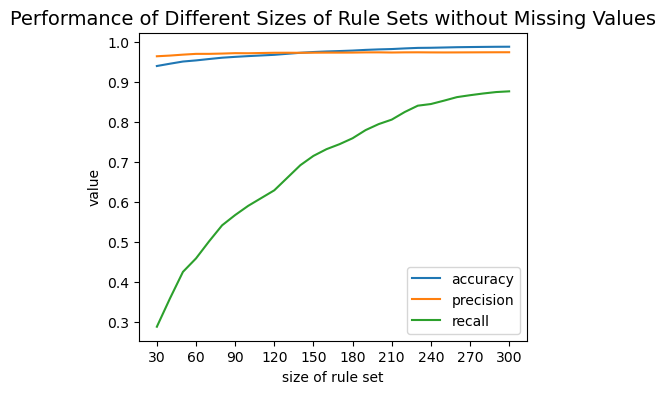

In [33]:
plt.figure(figsize=(5, 4))
plt.plot(range(30, 310, 10), acc_list, label=f"accuracy")
plt.plot(range(30, 310, 10), precision_list, label=f"precision")
plt.plot(range(30, 310, 10), recall_list, label=f"recall")
    
plt.title('Performance of Different Sizes of Rule Sets without Missing Values', fontsize=14)
plt.xlabel('size of rule set')
plt.ylabel('value')
plt.legend(loc='best')
plt.xticks(range(30, 310, 30))

plt.show()

#### From the above, it can be seen that the more rules you choose, the better the performance

#### The following missing value section uses 300 rules

# missing value 

In [79]:
df_use

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,n_195,r_195,n_196,r_196,r_197,r_198,n_199,r_199,r_206,label
0,406,2018-10-01,MA1,130.0,4.137765e+09,98.0,0.0,100.0,35996.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
1,406,2018-10-02,MA1,130.0,4.175147e+09,98.0,0.0,100.0,36019.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,406,2018-10-03,MA1,130.0,4.215511e+09,98.0,0.0,100.0,36043.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,406,2018-10-04,MA1,130.0,4.254417e+09,98.0,0.0,100.0,36067.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
4,406,2018-10-05,MA1,130.0,4.293503e+09,98.0,0.0,100.0,36091.0,-1.0,...,-1.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72709,19055,2018-12-28,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13259.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0
72710,19055,2018-12-29,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13283.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0
72711,19055,2018-12-30,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13307.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0
72712,19055,2018-12-31,MB1,-1.0,-1.000000e+00,99.0,2.0,97.0,13331.0,99.0,...,200.0,0.0,-1.0,-1.0,0.0,-1.0,100.0,0.0,-1.0,0


In [82]:
# choose rule set size = 300 to conduct the missing value part 

select_rules_missing = filter_dict[: 300]
rule_weight_rank = get_select_rule_rank(select_rules_missing)
print(len(rule_weight_rank))
print(rule_weight_rank)

303 0.04925022410033567
601 0.03292057536068723
307 0.04746642859610084
127 0.02858569047549478
300 0.04390741640477519
124 0.029485415756519286
299 0.03848341942380247
302 0.053605659542196295
304 0.05311444055139487
600 0.022498906011965143
319 0.029726247713392467
312 0.04469891950998303
321 0.03047042158392982
631 0.030217791398587452
301 0.027918316901328642
756 0.04465030469069631
306 0.04242326721480672
135 0.03601943160340177
364 0.051583582818965
372 0.05211971931745594
837 0.041159827936541424
52 0.026461146441640573
149 0.051046642314020056
308 0.022245357037531156
120 0.03779429504598993
793 0.03472405545116053
378 0.01855214090932779
48 0.0294824540164085
334 0.043826507050375135
132 0.0360066704931625
389 0.03340438555850272
69 0.027829788613503752
298 0.04105113293901405
339 0.035963364589010526
305 0.02532647213975688
320 0.04208818190324988
340 0.042423267214806715
297 0.0409261352772942
177 0.05096735137780909
331 0.04402830993250774
369 0.0473987453208336
179 0.05534

In [83]:
def trigger_rule_with_missing(missing_features, rule_index, rule, row, gamma=0.5):
    # check whether a record with missing value will trigger a rule
    total_abs_importance = 0
    for missing_feature in missing_features:

        difference_importance = shap_dict[missing_feature] - rule_weight[rule_index]
        
        if difference_importance > 0: # this feature is importance，cannot ignore，donot trigger
            return False
        
        # When<0, calculate the offset of the missing feature.
        # If the offset is greater than gamma, the feature is not important and ignored. 
        # Check if other features meet the rule
        
        # When there are multiple missing values
        # the offsets are added and divided by the number of missing features to obtain the average offset, which is compared with gamma

        abs_importance = abs(difference_importance) / rule_weight[rule_index]
        total_abs_importance += abs_importance
    avg_abs_importance = total_abs_importance / len(missing_feature)
        
    ignore_missing = avg_abs_importance > gamma
    
    if not ignore_missing: # this feature is importance， cannot ignore， donot trigger
        return False 
    
    trigger = True
    for feature in rule:
        if feature[0] in missing_features:
            continue
            
        if feature[1] == '>=':
            trigger = row[feature[0]] >= feature[2]
        elif feature[1] == '>':
            trigger = row[feature[0]] > feature[2]
        elif feature[1] == '==':
            trigger = row[feature[0]] == feature[2]
        elif feature[1] == '<':
            trigger = row[feature[0]] < feature[2]
        elif feature[1] == '<=':
            trigger = row[feature[0]] <= feature[2]
        if not trigger:
            break
    return trigger


In [84]:
col_names = list(feature_used)

In [88]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
import copy
feature_used = set(df_use.columns) - set(['disk_id', 'ds', 'model','label'])
cols_len = len(feature_used) - 1
column_names = list(feature_used)

missing_results = []
for gamma in [0.5, 0.6, 0.7, 0.8, 0.9]: # try different gamma
    for num_missing in range(1, cols_len):
        print(f"current loop: gamma = {gamma}, number of missing feature = {num_missing}")
        # copy
        missing_df = copy.deepcopy(df_use)
        feature_used = set(df_use.columns) - set(['disk_id', 'ds', 'model','label'])
        missing_df = missing_df[feature_used]

        # random delete features
        for index, row in missing_df.iterrows():
            missing_list = []
            while len(missing_list) < num_missing:
                tmp = random.randint(0, cols_len - 1)
                if tmp not in missing_list:
                    missing_list.append(tmp)
                    missing_df.at[index, column_names[tmp]] = 'lost'

        # analyze rules one by one for each row of missing_df
        y_pred_missing = []
        for index, row in missing_df.iterrows():
            # find missing features in current row
            find_lost = np.where(row.values == 'lost')
            if len(find_lost[0]) != num_missing:
                print(f"error! missing value number cannot match: {index}")
                break
                
            missing_feature =[col_names[f] for f in list(find_lost[0])]
            
            # sort by rule weight to check if trigger
            trigger = False
            for idx_weight in rule_weight_rank:
                rule_idx = idx_weight[0]
                rule = all_rules[rule_idx]['rule']
                rule_feature = [r[0] for r in rule]
                inter_feature = set(missing_feature) & set(rule_feature) # missing features have intersection with features in the rule
                
                if not inter_feature: # rule without missing feature
                    trigger = trigger_rule_without_missing(rule, row)
                else: # rule with missing feature
                    trigger = trigger_rule_with_missing(inter_feature, rule_idx, rule, row, gamma)

                if trigger: # if trigger，labeled as failed
                    break
            if trigger:
                y_pred_missing.append(1)
            else:
                y_pred_missing.append(0)
        
        missing_results.append(dict(
            gamma=gamma,
            num_missing=num_missing,
            acc=accuracy_score(df_use['label'], y_pred_missing),
            recall=recall_score(df_use['label'], y_pred_missing),
            precision=precision_score(df_use['label'], y_pred_missing),
#             y_pred_missing=y_pred_missing,
        ))


current loop: gamma = 0.5, number of missing feature = 1
current loop: gamma = 0.5, number of missing feature = 2
current loop: gamma = 0.5, number of missing feature = 3
current loop: gamma = 0.5, number of missing feature = 4
current loop: gamma = 0.5, number of missing feature = 5
current loop: gamma = 0.5, number of missing feature = 6
current loop: gamma = 0.5, number of missing feature = 7
current loop: gamma = 0.5, number of missing feature = 8
current loop: gamma = 0.5, number of missing feature = 9
current loop: gamma = 0.5, number of missing feature = 10
current loop: gamma = 0.5, number of missing feature = 11
current loop: gamma = 0.5, number of missing feature = 12
current loop: gamma = 0.5, number of missing feature = 13
current loop: gamma = 0.5, number of missing feature = 14
current loop: gamma = 0.5, number of missing feature = 15
current loop: gamma = 0.5, number of missing feature = 16
current loop: gamma = 0.5, number of missing feature = 17
current loop: gamma = 0

In [91]:
missing_results

[{'gamma': 0.5,
  'num_missing': 1,
  'acc': 0.9805126935665759,
  'recall': 0.787192118226601,
  'precision': 0.9753814852492371},
 {'gamma': 0.5,
  'num_missing': 2,
  'acc': 0.9727150204912397,
  'recall': 0.7022988505747126,
  'precision': 0.9615557553956835},
 {'gamma': 0.5,
  'num_missing': 3,
  'acc': 0.9636658690210963,
  'recall': 0.6238095238095238,
  'precision': 0.915421686746988},
 {'gamma': 0.5,
  'num_missing': 4,
  'acc': 0.9529526638611546,
  'recall': 0.5653530377668309,
  'precision': 0.816457197059521},
 {'gamma': 0.5,
  'num_missing': 5,
  'acc': 0.9391176389691118,
  'recall': 0.5067323481116585,
  'precision': 0.6844089598580616},
 {'gamma': 0.5,
  'num_missing': 6,
  'acc': 0.9240723932117612,
  'recall': 0.45714285714285713,
  'precision': 0.5569113822764553},
 {'gamma': 0.5,
  'num_missing': 7,
  'acc': 0.907363093764612,
  'recall': 0.42561576354679803,
  'precision': 0.44459691252144085},
 {'gamma': 0.5,
  'num_missing': 8,
  'acc': 0.8885909178425062,
  're

## performance for different γ and different number of missing features

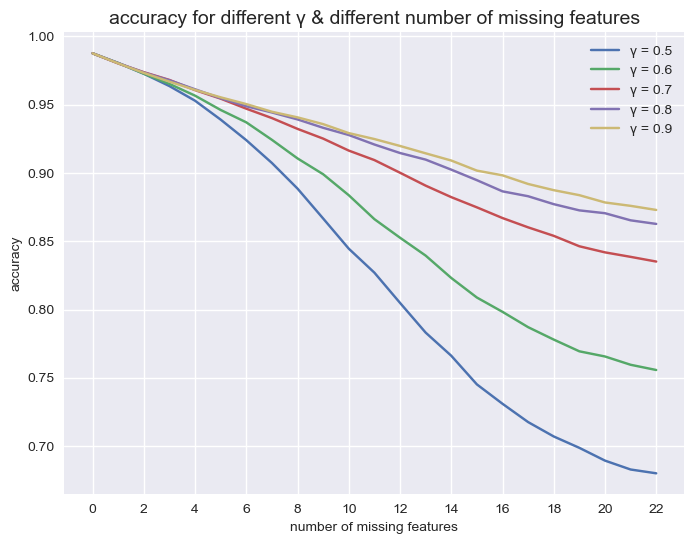

In [142]:
gamma_list = [0.5, 0.6, 0.7, 0.8, 0.9]
acc_y = {g: [0.9876777511895921] for g in gamma_list}
# acc_y = {g: [] for g in gamma_list}
plt.figure(figsize=(8, 6))


for res in missing_results:
    acc_y[res['gamma']].append(res['acc'])

for g in gamma_list:
    plt.plot(range(23), acc_y[g][: 23], label=f"γ = {g}")
    
plt.title('accuracy for different γ & different number of missing features', fontsize=14)
plt.xlabel('number of missing features')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.xticks(range(0, 24, 2))

plt.savefig('D:/ssd/acc.jpg')
plt.show()


In [106]:
print(acc_y)

{0.5: [0.9876777511895921, 0.9805126935665759, 0.9727150204912397, 0.9636658690210963, 0.9529526638611546, 0.9391176389691118, 0.9240723932117612, 0.907363093764612, 0.8885909178425062, 0.8667106746981325, 0.8446103913964298, 0.827048436339632, 0.8049206480182634, 0.7831641774623869, 0.7662073328382429, 0.7452347553428501, 0.7310421651951481, 0.7176334681079297, 0.7070990455758176, 0.6987650246169926, 0.6894133179305223, 0.6829083807794922, 0.6801166212833842, 0.6763759386087961, 0.6767197513546223, 0.6795802733998955, 0.6859751904722612, 0.6915724619743103, 0.7029182825865721, 0.7115961162912231, 0.7284154358170366, 0.7500206287647496, 0.7704981159061529, 0.798649503534395, 0.8336358885496603, 0.8716478257281954], 0.6: [0.9876777511895921, 0.9806227136452402, 0.9727425255109058, 0.9652749126715625, 0.9566658415160767, 0.9461864290232967, 0.9371235250433204, 0.9243199383887559, 0.9107049536540419, 0.8991253403746183, 0.8837500343812745, 0.8662293368539759, 0.8526418571389278, 0.8395494

###  as can be seen from the above, different γ values can achieve an accuracy of around 0.7 when the missing values reach 20

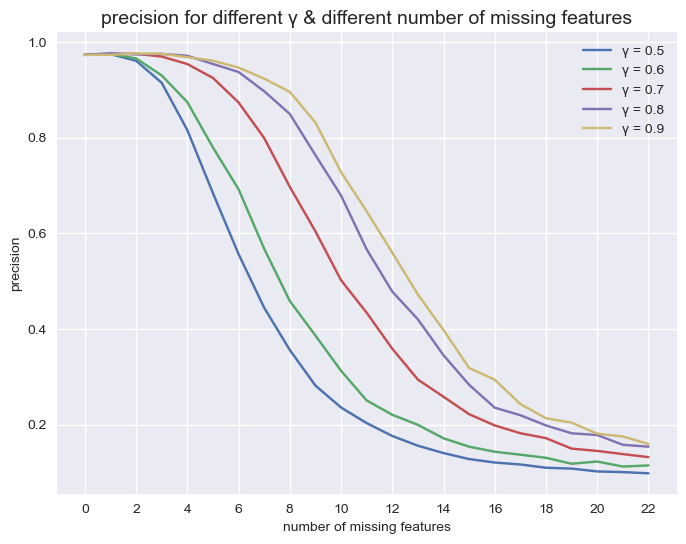

In [146]:
gamma_list = [0.5, 0.6, 0.7, 0.8, 0.9]
precision_y = {g: [0.9739051094890511] for g in gamma_list}

plt.figure(figsize=(8, 6))


for res in missing_results:
    precision_y[res['gamma']].append(res['precision'])

for g in gamma_list:
    plt.plot(range(23), precision_y[g][:23], label=f"γ = {g}")
    
plt.title('precision for different γ & different number of missing features', fontsize=14)
plt.xlabel('number of missing features')
plt.ylabel('precision')
plt.legend(loc='best')
plt.xticks(range(0, 24, 2))

plt.savefig('D:/ssd/precision.jpg')
plt.show()


In [163]:
acc_y[0.9][8]

0.9407679401490772

## as can be seen from the above precision diagram,
- Precision refers to failed precision
- As γ increases, the precision decreases more and more slowly as the missing value increases. 
- γ=0.9, the precision can still reach a precision of nearly 0.6 at 12 missing values
- γ=0.5, with 6 missing values, can reach close to 0.6, within an acceptable range

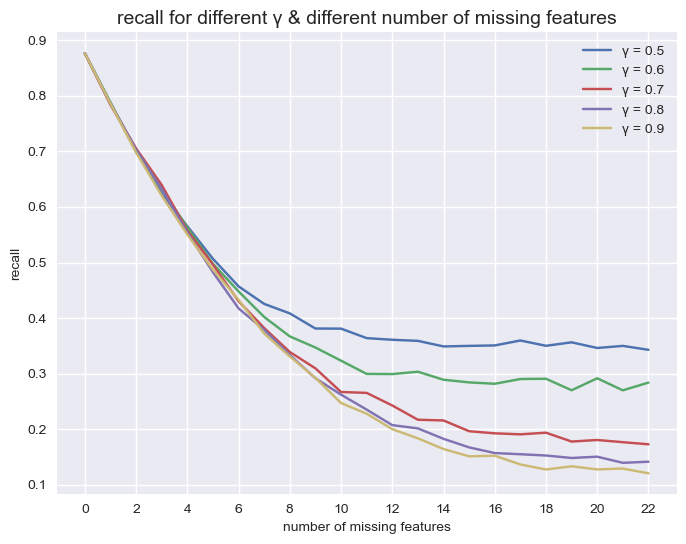

In [144]:
gamma_list = [0.5, 0.6, 0.7, 0.8, 0.9]
recall_y = {g: [0.8763546798029557] for g in gamma_list}

plt.figure(figsize=(8, 6))


for res in missing_results:
    recall_y[res['gamma']].append(res['recall'])

for g in gamma_list:
    plt.plot(range(23), recall_y[g][:23], label=f"γ = {g}")
    
plt.title('recall for different γ & different number of missing features', fontsize=14)
plt.xlabel('number of missing features')
plt.ylabel('recall')
plt.legend(loc='best')
plt.xticks(range(0, 24, 2))

plt.savefig('D:/ssd/recall.jpg')
plt.show()



## As can be seen from the recall diagram above,
- Recall refers to a failed recall
- Recall decreases as the missing value increases, and decreases faster and faster as the gamma increases, with only slight differences
- When the missing features are less than 6, there is no significant difference in recall for different γ values
- Overall, when the number of missing features is 9, recall can reach 0.3